In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

data_path = '/content/drive/MyDrive/Colab Notebooks/SolarPrediction.csv'  # 파일 경로를 지정해주세요.
data = pd.read_csv(data_path)

data['Data'] = pd.to_datetime(data['Data'], format='%Y-%m-%d', errors='coerce')
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce').dt.hour + pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce').dt.minute / 60
data['TimeSunRise'] = pd.to_datetime(data['TimeSunRise'], format='%H:%M:%S', errors='coerce').dt.hour + pd.to_datetime(data['TimeSunRise'], format='%H:%M:%S', errors='coerce').dt.minute / 60
data['TimeSunSet'] = pd.to_datetime(data['TimeSunSet'], format='%H:%M:%S', errors='coerce').dt.hour + pd.to_datetime(data['TimeSunSet'], format='%H:%M:%S', errors='coerce').dt.minute / 60
data['SunDuration'] = data['TimeSunSet'] - data['TimeSunRise']

features = data[['Temperature', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Pressure']]
target = data['Radiation']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("테스트 예측 값:", y_pred[:10])


Fitting 3 folds for each of 81 candidates, totalling 243 fits
최적의 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
테스트 예측 값: [676.2077    692.98267     2.4748518  21.07185     5.0577755 521.48047
  44.100277    8.550535  711.615     262.45547  ]


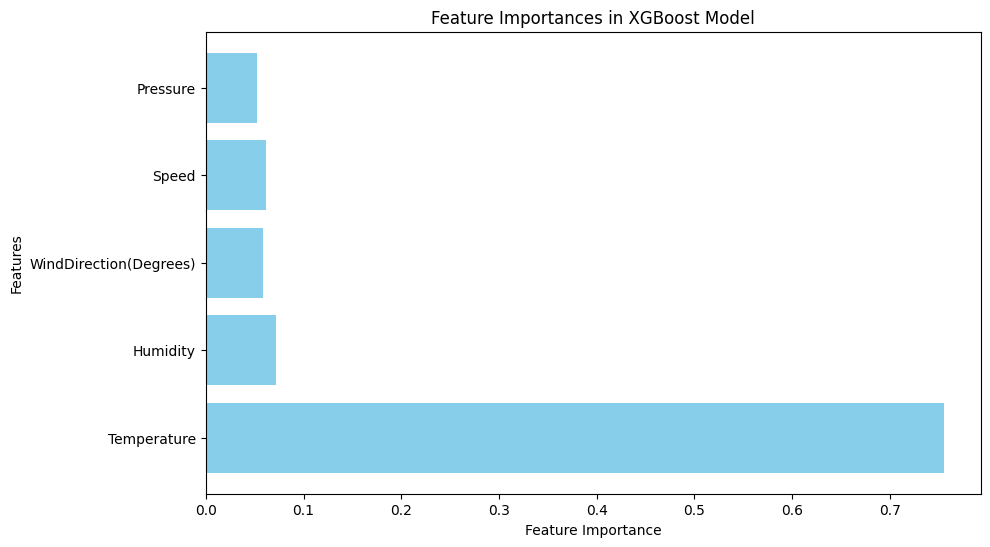

In [7]:
import matplotlib.pyplot as plt

feature_importances = best_model.feature_importances_
features_list = features.columns

plt.figure(figsize=(10, 6))
plt.barh(features_list, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances in XGBoost Model")
plt.show()
